In [ ]:
%pwd

In [ ]:
%cd ..

In [ ]:
%pwd

In [7]:
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from brainMRI.logging import logger
from dataclasses import dataclass, field
from typing import List
from collections import defaultdict
import random


@dataclass
class AnalyzeImageData: 
    data_folder: Path
    image_quality_and_format: Path
    image_counts_path:Path
    image_metadata_path: Path
    allowed_formats: tuple[str]
    image_samples_path: Path
    image_stats_results_path: Path
    plots_path: Path
    root: List[Path] = field(default_factory=list)


    def __post_init__(self) -> None:
        """
        This method is called automatically after an instance of the class is initialized.
        It walks through the directory specified by `self.data_folder` and collects all the unique
        directory paths where files are located.

        The collected directory paths are stored in the `self.root` list.
        """
        for root, _, files in os.walk(self.data_folder):
            for _ in files:
                if root not in self.root:
                    self.root.append(root)

    def analyzer(self) -> None:
        """
        This method calls all the other methods in the AnalyzeImageData class in a specific order.
        It ensures that the necessary data and analysis are performed for the image dataset.
        """
        try:
            self.get_image_metadata()
            self.check_image_quality_and_format()
            self.check_image_counts()
            self.visualize_images()
        except Exception as e:
            logger.error(f'Error running all methods: {e}')
            raise e

    def get_image_metadata(self) -> None:
        """
        This method collects metadata for all the images in the `self.data_folder` directory.
        The metadata includes the file path, class label, image width, height, and number of channels.
        The metadata is saved to a CSV file specified by `self.image_metadata_path`.
        After saving the metadata, this method also generates image statistics and plots.

        Raises:
            Exception: If any error occurs during the metadata collection process.
        """
        try:
            metadata = []

            for dir_path in self.root:
                label = os.path.basename(dir_path)

                for image_path in Path(dir_path).glob('*'):
                    image = Image.open(image_path)
                    width, height = image.size
                    channels = len(image.getbands())
                    metadata.append((str(image_path), str(label), width, height, channels))

            with open(self.image_metadata_path, 'w', newline='') as metadata_file:
                writer = csv.writer(metadata_file)
                writer.writerow(['File Path', 'class', 'Width', 'Height', 'Channels'])
                writer.writerows(metadata)

            logger.info("Image metadata saved to: image_metadata.csv")
            self._get_image_stats_and_plots(metadata)
        except Exception as e:
            logger.error(f'Error collecting image metadata: {e}')
            raise e

    def get_image_dimensions(self, image_path: str) -> tuple[int, int,int]:
        """
        Get the width, height, and number of channels of an image.
        
        Args:
            image_path (str): The full path to the image file.
            
        Returns:
            Tuple[int, int, int]: The width, height, and number of channels of the image.
        """
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                channels = len(img.getbands())
                logger.info(f"Extracted dimensions for {os.path.basename(image_path)}: {width}x{height}x{channels}")
                return (width, height, channels)
        except Exception as e:
            logger.error(f"Error getting dimensions for {os.path.basename(image_path)}: {e}")
            return (0, 0, 0)

    def check_image_quality_and_format(self) -> None:
        """
        This method checks the quality and format of all the images in the `self.data_folder` directory.
        It identifies two types of issues:
        1. Quality issues: Images that do not have the expected number of color channels (RGB, RGBA, Grayscale, or Palette).
        2. Format issues: Images that do not have the expected image mode (RGB, RGBA, Grayscale, or Palette).

        The results of the quality and format checks are saved to a text file specified by `self.image_quality_and_format`.

        Raises:
            Exception: If any error occurs during the image quality and format check.
        """
        try:
            quality_issues = []
            format_issues = []

            for dir_path in self.root:
                for image_path in Path(dir_path).glob('*'):
                    try:
                        image = Image.open(image_path)
                        if image.mode not in ('RGB', 'RGBA', 'L', 'P'):
                            format_issues.append((str(image_path), image.mode))
                        if image.getbands() not in (('R', 'G', 'B'), ('R', 'G', 'B', 'A'),('L',), ('P',)):
                            quality_issues.append((str(image_path), image.getbands()))
                    except Exception as e:
                        format_issues.append(str(image_path))
                        raise e
                        

            with open(self.image_quality_and_format, 'w') as quality_file:
                if quality_issues:
                    quality_file.write('Images with quality issues:\n')
                    for issue in quality_issues:
                        quality_file.write(f"{issue}\n")
                else:
                    quality_file.write('No image quality issues found.\n')

                if format_issues:
                    quality_file.write('\nImages with format issues:\n')
                    for issue in format_issues:
                        quality_file.write(f"{issue}\n")
                else:
                    quality_file.write('\nNo image format issues found.\n')

            logger.info("Image quality and format check saved to: image_quality_and_format.txt")
        except Exception as e:
            logger.error(f'Error checking image quality and format: {e}')
            raise e
    
    def check_image_counts(self) -> None:
        """
        This method checks the number of images in each class (directory) within the `self.data_folder` directory.
        It calculates the minimum and maximum image counts across all classes, and determines the level of class imbalance in the dataset.
        The results are saved to a text file specified by `self.image_counts_path`.

        The method will write the following information to the text file:
        - The number of images in each class
        - A warning if the dataset is imbalanced (the ratio of the maximum to minimum image count is greater than 2)
        - A message if the dataset has a moderate class imbalance (the ratio of the maximum to minimum image count is between 1 and 2)
        - A message if the dataset is well-balanced (the minimum and maximum image counts are equal)

        Raises:
            Exception: If any error occurs during the image count check.
        """
        try:
            image_counts = defaultdict(int)
            for dir_path in self.root:
                label = os.path.basename(dir_path)
                image_counts[label] = len(list(Path(dir_path).glob('*')))
                


            max_count = max(image_counts.values())
            min_count = min(image_counts.values())

            with open(self.image_counts_path, 'w') as counts_file:
                for label,count in image_counts.items():
                    counts_file.write(f"Number of class '{label}' images: {count}\n")
                
                if max_count != min_count:
                    imbalance_ratio = max_count / min_count
                    if imbalance_ratio > 2:
                        counts_file.write('\nWARNING: The dataset is imbalanced. Consider applying techniques to balance the classes.\n')
                    else:
                        counts_file.write('\nThe dataset has a moderate class imbalance. You may want to consider balancing the classes.\n')
                else:
                    counts_file.write('\nThe dataset is well-balanced.\n')

            logger.info("Image counts and class balance information saved to: image_counts.txt")
        except Exception as e:
            logger.error(f'Error checking image counts: {e}')
            raise e
        
    def _get_image_stats_and_plots(self, metadata) -> None:
        """
        This method calculates and saves various statistics and plots related to the image data.

        Args:
            metadata (List[Tuple[str, str, int, int, int]]): The image metadata, including file path, class label, width, height, and number of channels.

        """ 
        df = pd.DataFrame(metadata, columns=['File Path', 'class', 'Width', 'Height', 'Channels'])

        # Calculate overall statistics
        overall_min = df['Width'].min()
        overall_max = df['Width'].max()
        overall_width_mean = df['Width'].mean()
        overall_width_std = df['Width'].std()
        overall_height_mean = df['Height'].mean()
        overall_height_std = df['Height'].std()
        overall_channels_mean = df['Channels'].mean()
        overall_channels_std = df['Channels'].std()
        logger.info(f"Overall statistics: Min width={overall_min}, Max width={overall_max}, Avg width={overall_width_mean:.2f}, Width std={overall_width_std:.2f}, Avg height={overall_height_mean:.2f}, Height std={overall_height_std:.2f}, Avg channels={overall_channels_mean:.2f}, Channels std={overall_channels_std:.2f}")

        # Calculate statistics for each class
        class_stats = df.groupby('class').agg({
            'Width': ['min', 'max', 'mean', 'std'],
            'Height': ['min', 'max', 'mean', 'std'],
            'Channels': ['min', 'max', 'mean', 'std'],
            'File Path': 'count'
        })
        class_stats.columns = ['Width Min', 'Width Max', 'Width Mean', 'Width Std',
                            'Height Min', 'Height Max', 'Height Mean', 'Height Std',
                            'Channels Min', 'Channels Max', 'Channels Mean', 'Channels Std',
                            'Count']
        for index, row in class_stats.iterrows():
            logger.info(f"Class: {index}, Width Min={row['Width Min']}, Width Max={row['Width Max']}, Width Mean={row['Width Mean']:.2f}, Width Std={row['Width Std']:.2f}, Height Min={row['Height Min']}, Height Max={row['Height Max']}, Height Mean={row['Height Mean']:.2f}, Height Std={row['Height Std']:.2f}, Channels Min={row['Channels Min']}, Channels Max={row['Channels Max']}, Channels Mean={row['Channels Mean']:.2f}, Channels Std={row['Channels Std']:.2f}, Count={row['Count']}")

        # Save results to a text file
        with open(self.image_stats_results_path, 'w') as f:
            f.write('Overall Statistics:\n')
            f.write(f"Min width: {overall_min}\n")
            f.write(f"Max width: {overall_max}\n")
            f.write(f"Average width: {overall_width_mean:.2f}\n")
            f.write(f"Width standard deviation: {overall_width_std:.2f}\n")
            f.write(f"Average height: {overall_height_mean:.2f}\n")
            f.write(f"Height standard deviation: {overall_height_std:.2f}\n")
            f.write(f"Average channels: {overall_channels_mean:.2f}\n")
            f.write(f"Channels standard deviation: {overall_channels_std:.2f}\n\n")

            f.write('Per-Class Statistics:\n')
            for index, row in class_stats.iterrows():
                f.write(f"Class: {index}\n")
                f.write(f"Width Min: {row['Width Min']}\n")
                f.write(f"Width Max: {row['Width Max']}\n")
                f.write(f"Width Mean: {row['Width Mean']:.2f}\n")
                f.write(f"Width Standard Deviation: {row['Width Std']:.2f}\n")
                f.write(f"Height Min: {row['Height Min']}\n")
                f.write(f"Height Max: {row['Height Max']}\n")
                f.write(f"Height Mean: {row['Height Mean']:.2f}\n")
                f.write(f"Height Standard Deviation: {row['Height Std']:.2f}\n")
                f.write(f"Channels Min: {row['Channels Min']}\n")
                f.write(f"Channels Max: {row['Channels Max']}\n")
                f.write(f"Channels Mean: {row['Channels Mean']:.2f}\n")
                f.write(f"Channels Standard Deviation: {row['Channels Std']:.2f}\n")
                f.write(f"Image Count: {row['Count']}\n\n")
        logger.info(f'Saved results to {self.image_stats_results_path}')

        # Generate and save plots
        os.makedirs(self.plots_path, exist_ok=True)

        plt.figure(figsize=(12, 6))
        sns.barplot(x=class_stats.index, y='Count', data=class_stats)
        plt.xlabel('Class')
        plt.ylabel('Number of Images')
        plt.title('Image Statistics by Class')
        plt.xticks(rotation=90)
        plt.savefig(os.path.join(self.plots_path, 'image_stats_bar.png'))
        logger.info(f'Saved bar plot to {os.path.join(self.plots_path, "image_stats_bar.png")}')

        plt.figure(figsize=(8, 8))
        class_stats['Count'].plot(kind='pie', autopct='%1.1f%%')
        plt.title('Image Distribution by Class')
        plt.savefig(os.path.join(self.plots_path, 'image_stats_pie.png'))
        logger.info(f'Saved pie chart to {os.path.join(self.plots_path, "image_stats_pie.png")}')

        plt.figure(figsize=(12, 6))
        sns.histplot(df['Width'], bins=30 , kde=True)
        plt.xlabel('Width')
        plt.ylabel('Frequency')
        plt.title('Image Width Distribution')
        plt.savefig(os.path.join(self.plots_path, 'image_stats_width_distribution.png'))
        logger.info(f'Saved width distribution plot to {os.path.join(self.plots_path, "image_stats_width_distribution.png")}')

        plt.figure(figsize=(12, 6))
        sns.histplot(df['Height'], bins=30, kde=True)
        plt.xlabel('Height')
        plt.ylabel('Frequency')
        plt.title('Image Height Distribution')
        plt.savefig(os.path.join(self.plots_path, 'image_stats_height_distribution.png'))
        logger.info(f'Saved height distribution plot to {os.path.join(self.plots_path, "image_stats_height_distribution.png")}')

        plt.figure(figsize=(12, 6))
        sns.histplot(df['Channels'], bins=10, kde=True)
        plt.xlabel('Channels')
        plt.ylabel('Frequency')
        plt.title('Image Channels Distribution')
        plt.savefig(os.path.join(self.plots_path, 'image_stats_channels_distribution.png'))
        logger.info(f'Saved channels distribution plot to {os.path.join(self.plots_path, "image_stats_channels_distribution.png")}')
    
    def visualize_images(self, num_images_per_class=3) -> None:
        """
        Visualizes a random sample of images from each class and saves the resulting image to a file.
        
        Args:
            num_images_per_class (int): The number of images to visualize per class.
        """
        try:
            # Get a list of all subfolders (classes)
            subfolders = self.root
           
            # Check if there are any subfolders
            if not subfolders:
                logger.warning("No subfolders found. Cannot visualize images.")
                return

            # Visualize and save the images
            fig, axes = plt.subplots(len(subfolders), num_images_per_class, figsize=(15, 3 * len(subfolders)))
            for i, subfolder in enumerate(subfolders):
                class_images = [str(p) for p in Path(subfolder).glob('*')]
                print(class_images)
                for j in range(num_images_per_class):
                    image_path = random.choice(class_images)
                    image = plt.imread(image_path)
                    axes[i, j].imshow(image)
                    axes[i, j].set_title(os.path.basename(subfolder))
                    axes[i, j].axis('off')
            
            
            plt.savefig(self.image_samples_path)
            logger.info(f"Image samples saved to: {self.image_samples_path}")
        except Exception as e:
            logger.error(f'Error visualizing images: {e}')
            raise e


In [8]:
from brainMRI.constants import *
from brainMRI.utils.helpers import load_config, create_directories

class ConfigHandler:
    def __init__(self, file_path=CONFIG_FILE_PATH, params_path = PARAMS_FILE_PATH):
        self.config = load_config(file_path)
        create_directories([self.config.root_dir])



    def get_analyze_image_data_config(self) -> AnalyzeImageData:
        config = self.config['info']
        create_directories([config.root_dir])
        analyze_image_data_config = AnalyzeImageData(
            data_folder=config.data_folder,
            image_quality_and_format=config.image_quality_and_format,
            image_counts_path=config.image_counts_path,
            allowed_formats=config.allowed_formats,
            image_metadata_path=config.image_metadata_path,
            image_samples_path=config.image_samples_path,
            image_stats_results_path=config.image_stats_results_path,
            plots_path=config.plots_path,
        )
        return analyze_image_data_config


[2024-05-16 14:52:00,808: INFO: helpers: YAML file: config\config.yaml loaded successfully]
[2024-05-16 14:52:00,811: INFO: helpers: Created directory at: project_outputs]
[2024-05-16 14:52:00,812: INFO: helpers: Created directory at: project_outputs/data/info]
[2024-05-16 14:52:00,976: INFO: 161729560: Image metadata saved to: image_metadata.csv]
[2024-05-16 14:52:00,979: INFO: 161729560: Overall statistics: Min width=150, Max width=1920, Avg width=354.24, Width std=217.11, Avg height=386.02, Height std=213.13, Avg channels=2.77, Channels std=0.68]
[2024-05-16 14:52:00,990: INFO: 161729560: Class: no, Width Min=150.0, Width Max=1920.0, Width Mean=343.16, Width Std=231.85, Height Min=168.0, Height Max=1080.0, Height Mean=342.23, Height Std=182.36, Channels Min=1.0, Channels Max=4.0, Channels Mean=2.77, Channels Std=0.76, Count=98.0]
[2024-05-16 14:52:00,992: INFO: 161729560: Class: yes, Width Min=178.0, Width Max=1275.0, Width Mean=361.24, Width Std=207.72, Height Min=173.0, Height Max

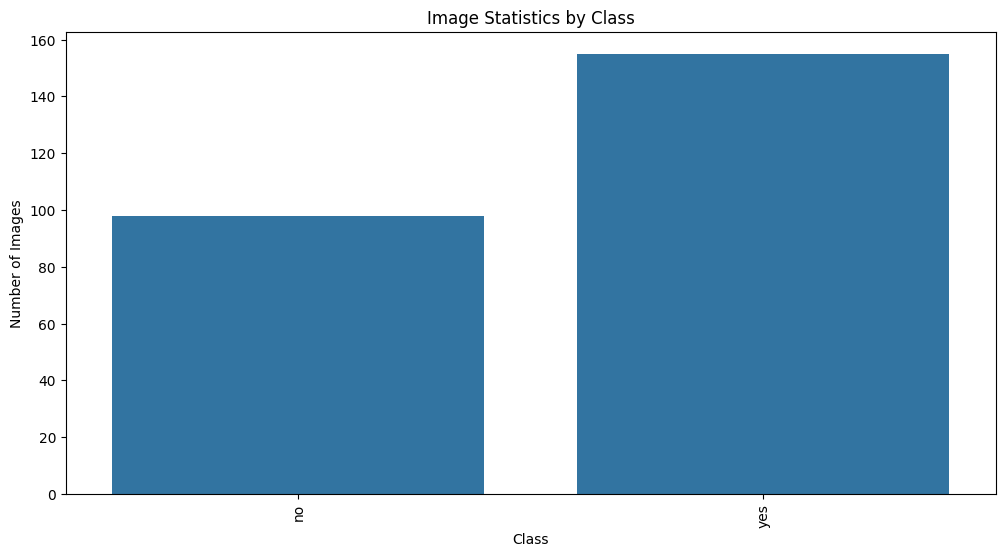

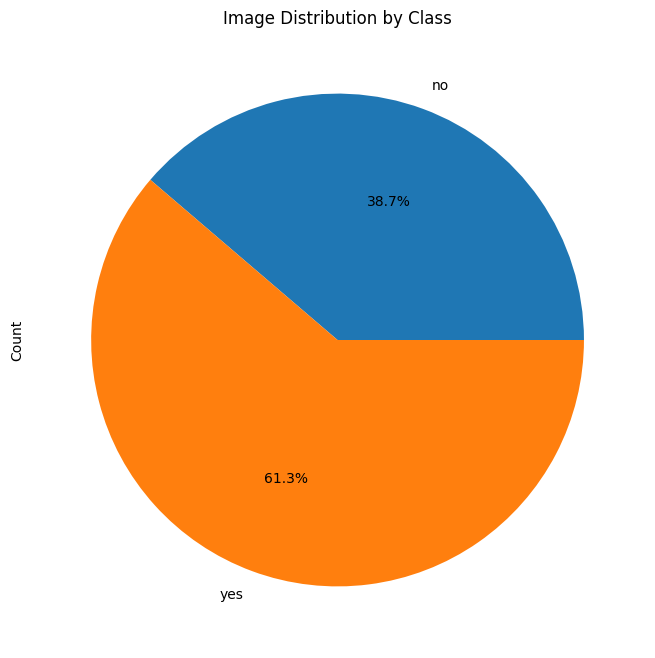

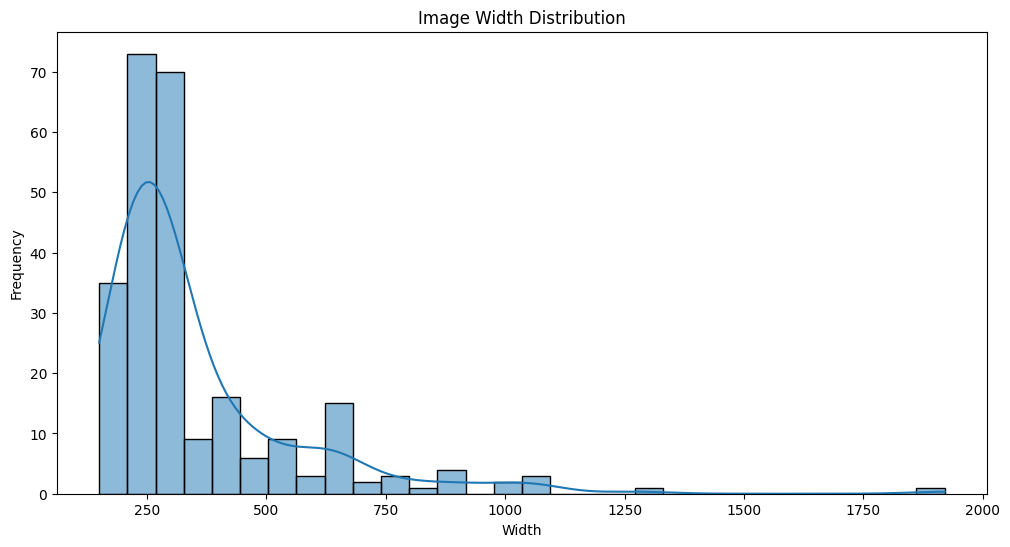

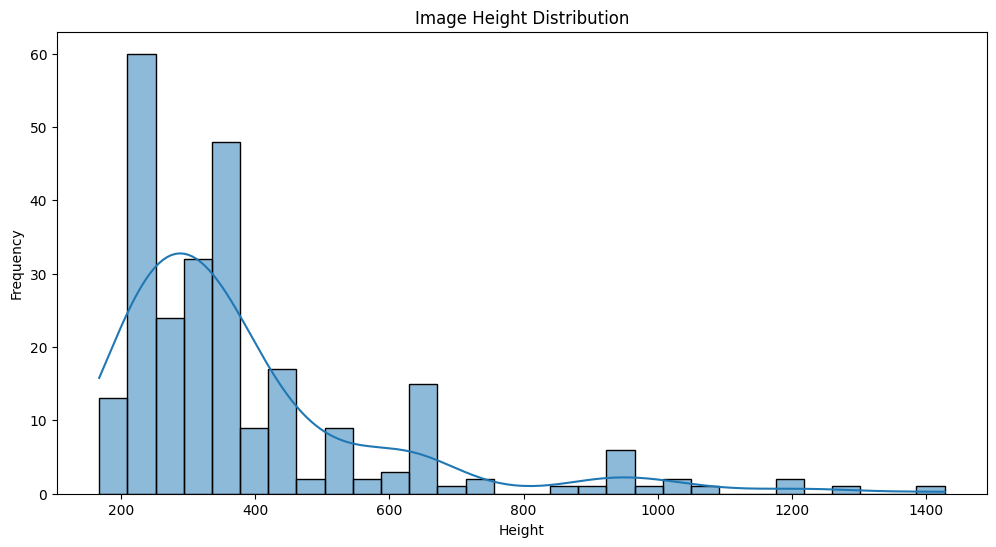

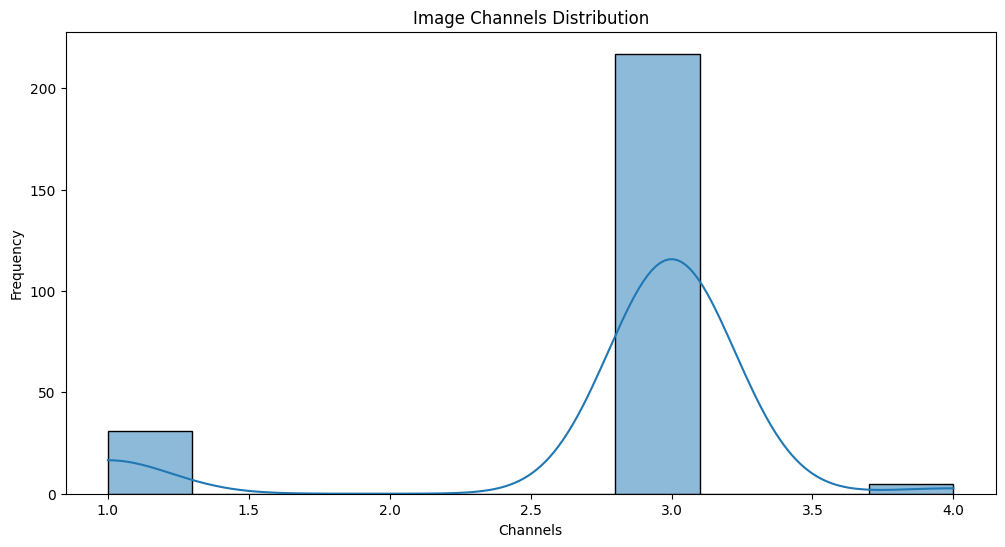

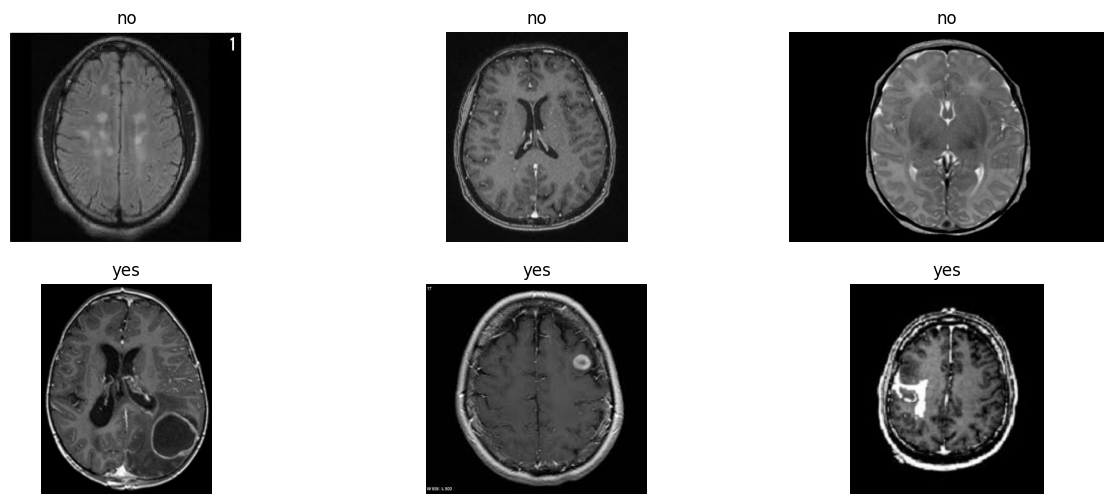

In [9]:
try:
    config = ConfigHandler()
    analyzer_config = config.get_analyze_image_data_config()
    analyzer_config.analyzer()
except Exception as e:
    raise e
